In [ ]:
import cv2
import numpy as np 
import pandas as pd 
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'

In [ ]:
pd_img_list=pd.read_csv('../../data/preprocessing_dataset/data_set.csv')['file_path']
pd_label_list=pd.read_csv('../../data/preprocessing_dataset/data_set.csv')
Train_img_list=pd_img_list[pd_img_list.str.contains('Train')].to_list() ## df[조건식]
Test_img_list=pd_img_list[pd_img_list.str.contains('Test')].to_list() ## df[조건식]
Train_label_list=pd_label_list[pd_label_list['file_path'].str.contains('Train')]['standard_frame'].to_list()
Test_label_list=pd_label_list[pd_label_list['file_path'].str.contains('Test')]['standard_frame'].to_list()

In [ ]:
size=256
origin_x_test = np.zeros((len(Test_img_list),size,size,3))
origin_y_test = np.zeros((len(Test_label_list),1))
for i in range(len(Test_img_list)):
    origin_x_test[i] =np.array(Image.open('../../data/original_dataset/'+Test_img_list[i]).resize((size,size)))
origin_x_test=origin_x_test/255
origin_y_test=np.array(Test_label_list)
origin_x_test, x_val, origin_y_test, y_val = train_test_split(origin_x_test, origin_y_test, test_size=0.5, random_state=42)


In [ ]:
preprocess_x_test = np.zeros((len(Test_img_list),size,size,3))
preprocess_y_test = np.zeros((len(Test_label_list),1))
for i in range(len(Test_img_list)):
    preprocess_x_test[i] =np.array(Image.open('../../data/preprocessing_dataset/'+Test_img_list[i]).resize((size,size)))
preprocess_x_test=preprocess_x_test/255
preprocess_y_test=np.array(Test_label_list)
preprocess_x_test, x_val, preprocess_y_test, y_val = train_test_split(preprocess_x_test, preprocess_y_test, test_size=0.5, random_state=42)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fper, tper):
    
    plt.plot(fper, tper, color='red', label='auc='+str(auc_score))
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

pre_model = K.models.load_model('../../model/resnet50_preprocessing.h5')
classes = ['NotStandardFrame','StandardFrame']
pre_prob = pre_model.predict(x_val)

fper, tper, thresholds = roc_curve(y_val, pre_prob)
auc_score=roc_auc_score(y_val, pre_prob)
plot_roc_curve(fper, tper)
pre_t_prob=np.where(pre_prob>0.5,1,0)

cm = confusion_matrix(y_val, pre_t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()


# F1 점수, 재현율, 정밀도 계산
report = classification_report(y_val, pre_t_prob, target_names=classes)

# 결과 출력
print(report)

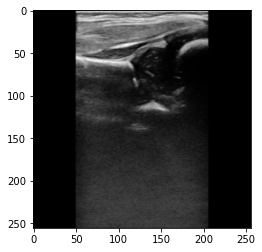

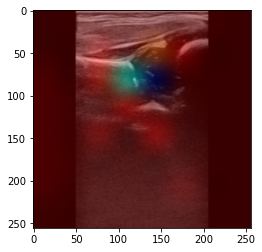

In [141]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
resnet = pre_model.get_layer('resnet50')
last_conv_layer=resnet.get_layer('conv5_block3_out')
model_1= keras.Model(resnet.inputs, last_conv_layer.output)
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = resnet.get_layer("avg_pool")(input_2)
x_2 = resnet.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

for image_index in np.where(y_val==1)[0]:
    with tf.GradientTape() as tape:
        output_1 = model_1(x_val[image_index:image_index+1])
        tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
        preds = model_2(output_1)
        class_id = tf.argmax(preds[0])
        output_2 = preds[:,class_id]

    grads = tape.gradient(output_2, output_1) #그레디언트 계산
    pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용

    output_1 = output_1.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        output_1[:,:,i]*=pooled_grads[i]
    heatmap=np.mean(output_1, axis=-1)

    heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화

    #열지도를 입력 영상에 씌움
    img =x_val[image_index]
    heatmap=np.uint8(255*heatmap) # [0,255]로 변환

    jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
    color = jet(np.arange(256))[:,:3]
    color_heatmap = color[heatmap]

    color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
    color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
    color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

    overlay_img= color_heatmap*0.0025+img #덧씌움
    overlay_img = (overlay_img/overlay_img.max()*255).astype(np.uint8)  # 이미지의 픽셀 깊이를 8비트로 변환
    overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR) 
    img = (img/img.max()*255).astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite('../../data/heatmap/img/'+str(image_index)+'.jpg',img)
    cv2.imwrite('../../data/heatmap/heat/'+str(image_index)+'.jpg',overlay_img)
plt.imshow(img)
plt.show()
plt.imshow(overlay_img)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])